**3DSegmentation with a public dataset.**

Scaling medical imaging, use 3D UNet model, Cache I/O for training and acceleration and validation, and sliding window for inference.

In [ ]:
!pip install monai
!pip install monai-weekly
!python -c "import matplotlib" || pip install -q matplotlib
!pip install -q pytorch-lightning~=2.0
!python -c "import monai; print(monai.__version__)"
!python -c "import monai" || pip install -q "monai-weekly[nibabel"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [ ]:
import os, shutil, tempfile, PIL, logging, sys, glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import pytorch_lightning

import monai
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.data import (
    DataLoader, decollate_batch, list_data_collate, CacheDataset)
from monai.apps import download_and_extract, DecathlonDataset

from monai.config import print_config
from monai.transforms import ( AsDiscrete, EnsureChannelFirstd, Compose,
    CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld,
    ScaleIntensityRanged, Spacingd, EnsureType )

from monai.utils import set_determinism
print_config()

In [ ]:
''' seed/deterministic training for reproduceability '''
set_determinism(seed=0)
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!mkdir monai
os.environ['monai'] = '/content/monai'
dir = os.environ.get('monai')
rootdir = tempfile.mkdtemp() if dir is None else dir
rootdir

'/content/monai'

In [ ]:
''' Dataset available from Medical Decathlon '''
resource = 'https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar'
md5 = '410d4a301da4e5b2f6f86ec3ddba524e'
compressed_file = os.path.join(rootdir, "Task09_Spleen.tar")
data_dir = os.path.join(rootdir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, rootdir, md5)

Task09_Spleen.tar: 1.50GB [01:42, 15.8MB/s]                            

2025-07-05 17:28:11,294 - INFO - Downloaded: /content/monai/Task09_Spleen.tar


2025-07-05 17:28:14,130 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-07-05 17:28:14,131 - INFO - Writing into directory: /content/monai.


In [ ]:
''' PyTorch Lightining Module for refactoring of the code '''
class Net(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(spatial_dims=3, in_channels=1, out_channels=2,
                          channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
                          num_res_units=2, norm=Norm.BATCH)
        self.loss_function = DiceLoss(to_onehot_y=True, softmax=True)
        self.post_pred = Compose([EnsureType('tensor', device='cpu'),
                                  AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType("tensor", device="cpu"),
                                  AsDiscrete(argmax=True, to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=False, reduction='mean',
                                    get_not_nans='False')
        self.best_val_dice = 0
        self.best_val_epoch = 0
        self.validation_step_outputs = []

    def forward(self, x):
      return self._model(x)

    def prepare_data(self):
      # set up the correct data path
      train_images = sorted(
          glob.glob(os.path.join(data_dir, 'imagesTr', '*.nii.gz')))
      train_labels = sorted(
          glob.glob(os.path.join(data_dir, 'labelsTr', '*.nii.gz')))
      data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
      train_files, val_files = data_dicts[:-9], data_dicts[-9:]

      set_determinism(seed=0)

      train_transforms = Compose([
          LoadImaged(keys=['image', 'label']),
          EnsureChannelFirstd(keys=['image', 'label']),
          Orientationd(keys=['image', 'label'], axcodes='RAS'),
          Spacingd(keys=['image', 'label'],
                   pixdim=(1.5, 1.5, 2.0), mode=('bilinear', 'nearest')),
          ScaleIntensityRanged(keys=["image"],
                   a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
          CropForegroundd(keys=['image', 'label'], source_key='image'),
          RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label',
                   spatial_size=(96, 96, 96), pos=1, neg=1, num_samples=4,
                   image_key='image', image_threshold=0), ])

      val_transforms = Compose([
          LoadImaged(keys=['image', 'label']),
          EnsureChannelFirstd(keys=['image', 'label']),
          Orientationd(keys=['image', 'label'], axcodes='RAS'),
          Spacingd(keys=["image", "label"],
                   pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
          ScaleIntensityRanged(keys=["image"], a_min=-57,
                   a_max=164, b_min=0.0, b_max=1.0, clip=True),
          CropForegroundd(keys=["image", "label"], source_key='image')
      ])

      self.train_ds = CacheDataset(data = train_files,
          transform = train_transforms, cache_rate = 1.0, num_workers = 4)

      self.val_ds = CacheDataset(data = val_files,
          transform = val_transforms, cache_rate = 1.0, num_workers = 4)

    def train_dataloader(self):
      train_loader = DataLoader(self.train_ds, batch_size=2, shuffle=True,
                                num_workers=4, collate_fn=list_data_collate)
      return train_loader

    def val_dataloader(self):
      val_loader = DataLoader(self.val_ds, batch_size=1, num_workers=4)
      return val_loader

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
      return optimizer

    def training_step(self, batch, batch_idx):
      images, labels = batch["image"], batch["label"]
      output = self.forward(images)
      loss = self.loss_function(output, labels)
      tensorboard_logs = {"train_loss": loss.item()}
      return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
      images, labels = batch["image"], batch["label"]
      roi_size = (160, 160, 160)
      sw_batch_size = 4
      outputs = sliding_window_inference(
          images, roi_size, sw_batch_size, self.forward)
      loss = self.loss_function(outputs, labels)
      outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
      labels = [self.post_label(i) for i in decollate_batch(labels)]
      self.dice_metric(y_pred=outputs, y=labels)
      d = {"val_loss": loss, "val_number": len(outputs)}
      self.validation_step_outputs.append(d)
      return d

    def on_validation_epoch_end(self):
      val_loss, num_items = 0, 0
      for output in self.validation_step_outputs:
        val_loss += output["val_loss"].sum().item()
        num_items += output["val_number"]
      '''
      mean_val_dice = self.dice_metric.aggregate().item()
      self.dice_metric.reset()
      mean_val_loss = torch.tensor(val_loss / num_items)
      tensorboard_logs = {
              "val_dice": mean_val_dice, "val_loss": mean_val_loss, }
      if mean_val_dice > self.best_val_dice:
                 self.best_val_dice = mean_val_dice
                 self.best_val_epoch = self.current_epoch
      print(f'epoch: {self.current_epoch}, mean dice: {mean_val_dice:.4f},\nbest \
          mean dice: {self.best_val_dice:.4f}, at epoch: {self.best_val_epoch}')
      '''
      self.validation_step_outputs.clear() # free memory
      #return {"log": tensorboard_logs}

In [ ]:
net = Net()
trainer = pytorch_lightning.Trainer(devices = [0], max_epochs = 100,
                enable_checkpointing = True, num_sanity_val_steps = 1)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(net)

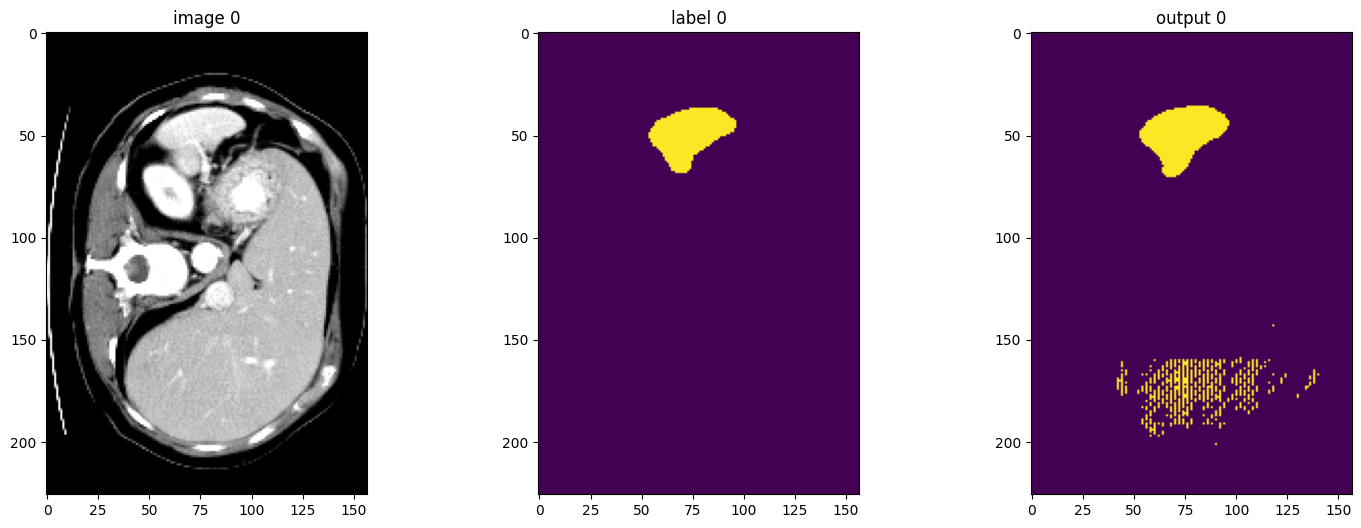

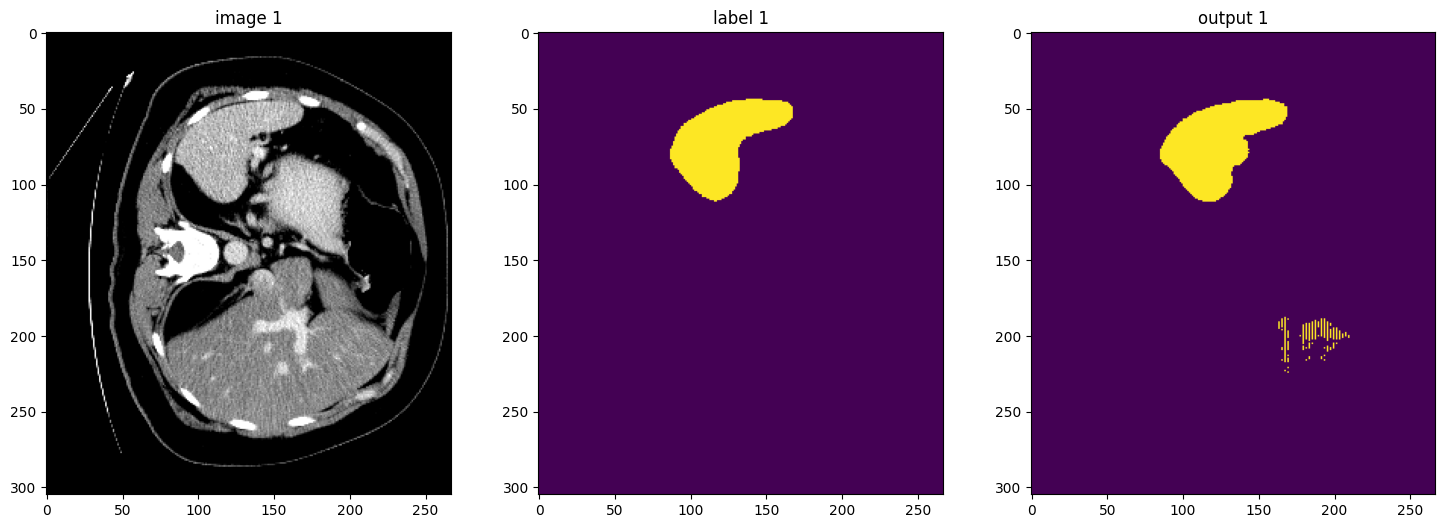

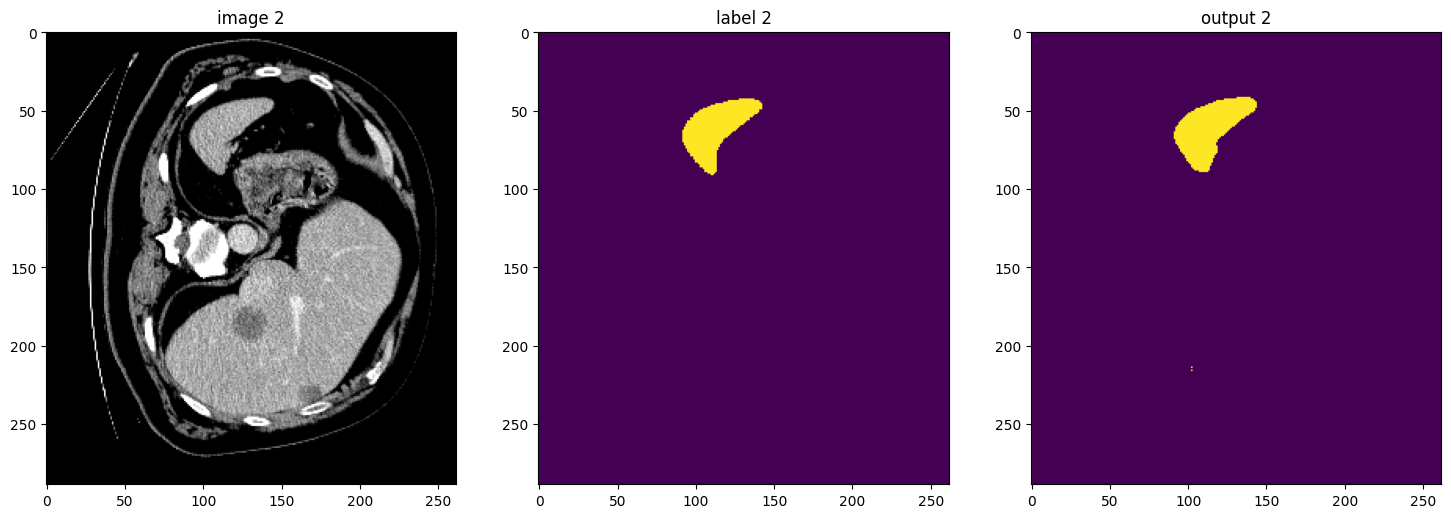

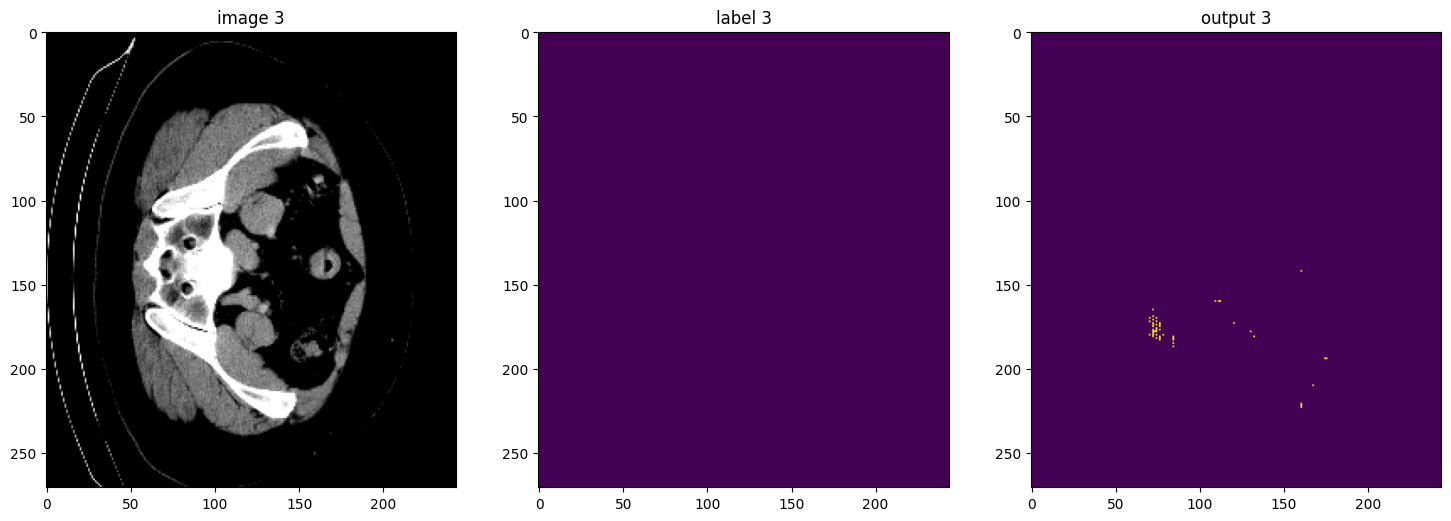

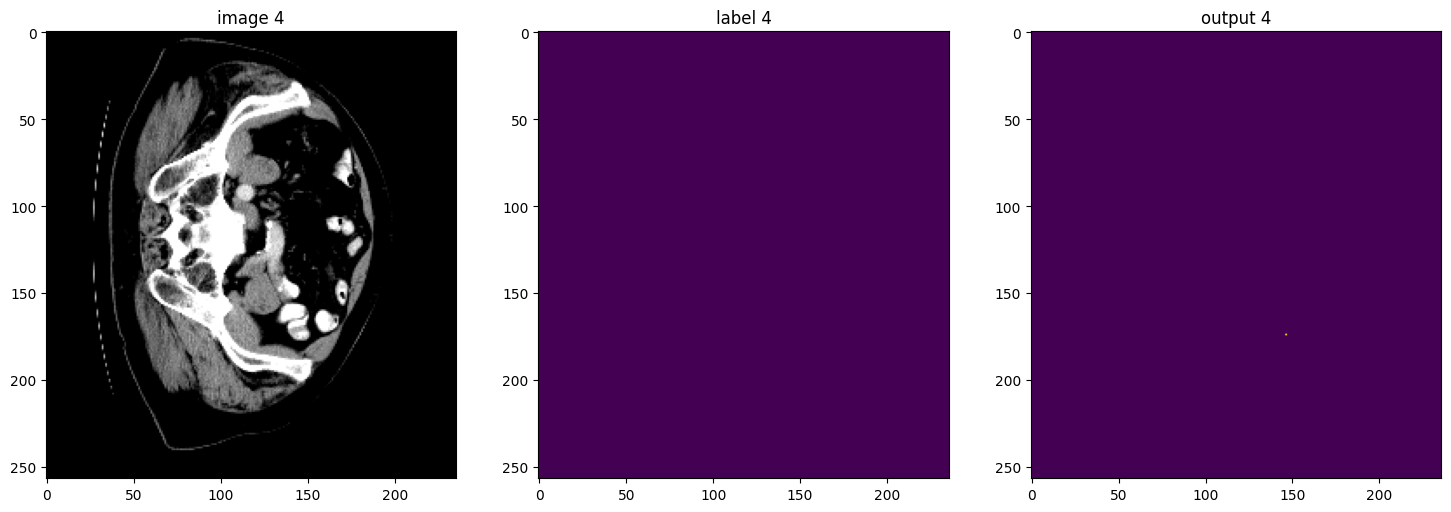

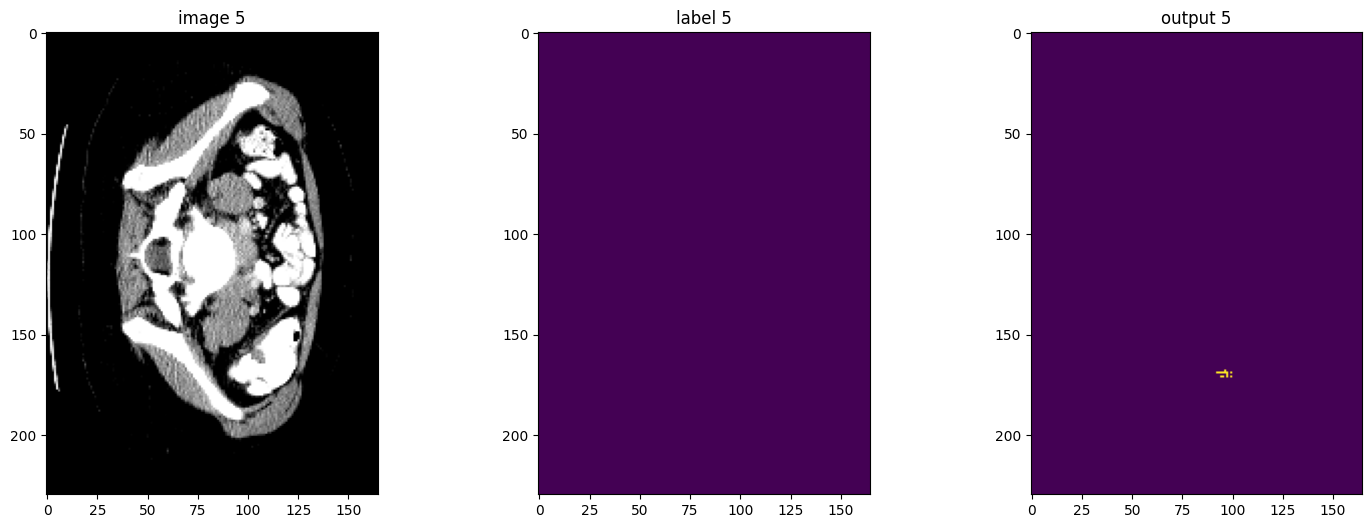

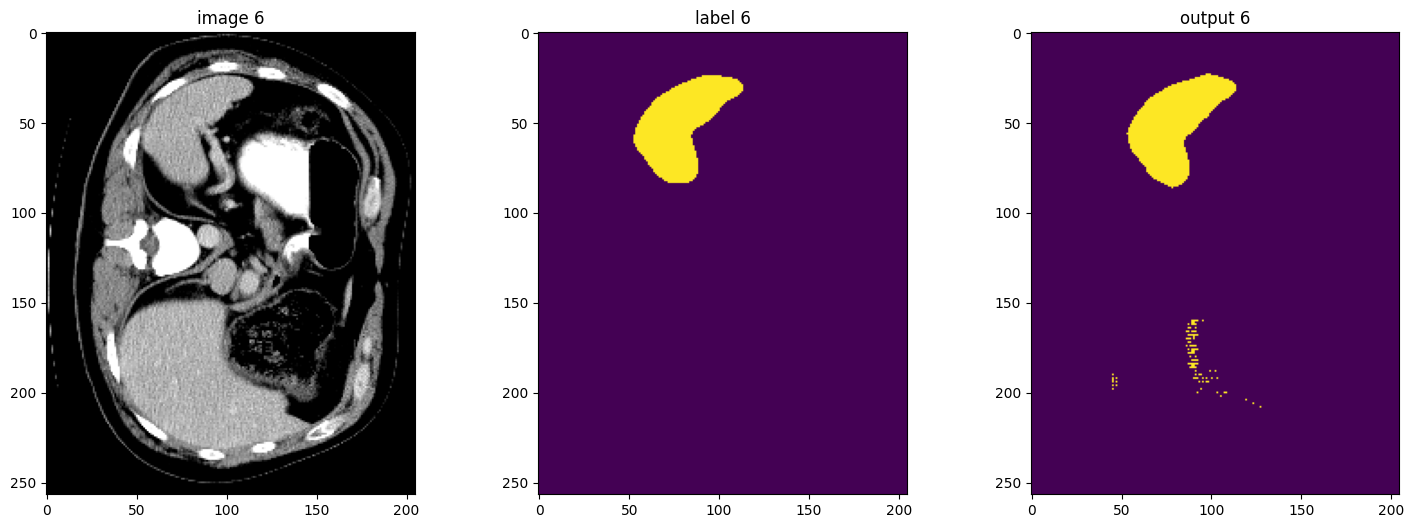

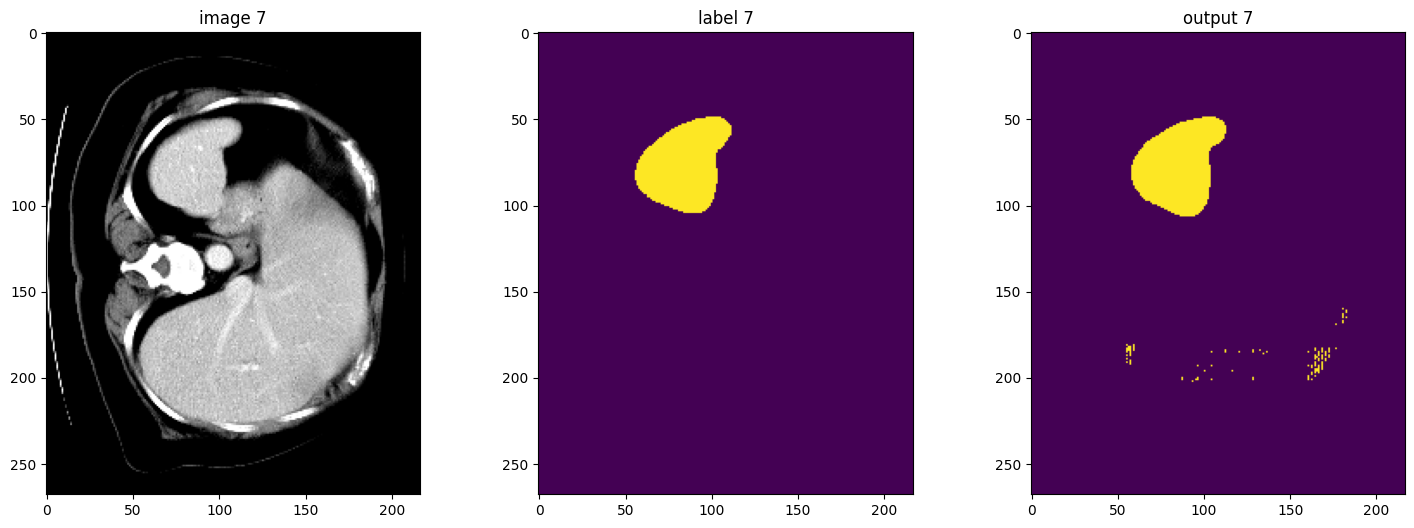

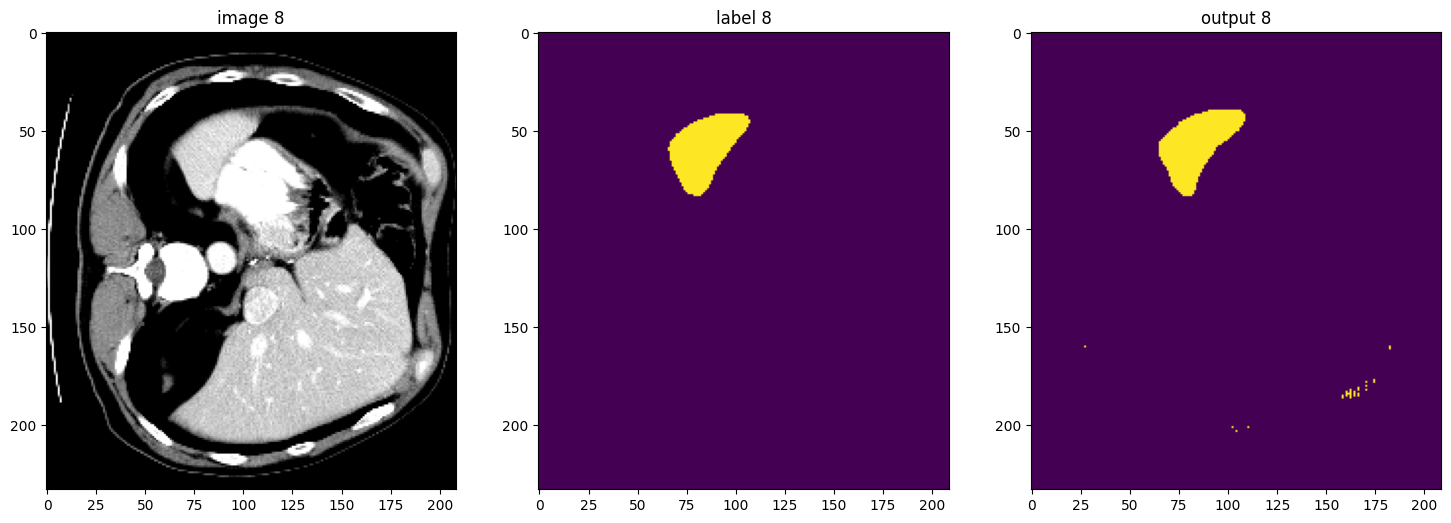

In [ ]:
''' check model output with input sample image and label '''
net.eval()
device = torch.device('cuda:0')
net.to(device)
with torch.no_grad():
  for i, val_data in enumerate(net.val_dataloader()):
    roi_size = (160, 160, 160)
    sw_batch_size = 4
    val_outputs = sliding_window_inference(
        val_data['image'].to(device), roi_size, sw_batch_size, net)
    plt.figure('check', (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f'image {i}')
    plt.imshow(val_data['image'][0, 0, :, :, 80], cmap = 'gray')
    plt.subplot(1, 3, 2)
    plt.title(f'label {i}')
    plt.imshow(val_data['label'][0, 0, :, :, 80])
    plt.subplot(1, 3, 3)
    plt.title(f'output {i}')
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
    plt.show()